# U-Net pipeline demo

In [97]:
import sys
sys.path.append('./preprocessor_module')
sys.path.append('./data_splitter_module')
sys.path.append('./trainer_module')
sys.path.append('./evaluator_module')

import matplotlib.pyplot as plt
import numpy as np
import h5py
import tqdm

from monai.transforms import (
    Transform,
    Compose,
    Activations,
    AsDiscrete,
)

from preprocessor_module import (
    constants          as ct,
    list_dicom_files   as lf,
    dicom_transforms   as dt,
    dicom_preprocessor as dp,
)

from data_splitter_module import (
    data_splitter,
)

from trainer_module import (
    models,
    trainer,
)

## 1. Preprocessing phase

### 1.1. Preprocessing step-by-step

In [98]:
# Provide the path to the data directory
data_dir = './data'

# List "metadata" (filepath, points filepath, dataset, subject id, subject visit) of all `.dcm` files in the data directory
all_files_meta = lf.ListDicomFiles(data_dir)()

# Select some `.dcm` file
some_file_meta = all_files_meta[-1]

# Extract file metadata
(
    dicom_filepath,
    points_filepath,
    dataset_name,
    subject_id,
    subject_visit,
) = \
    some_file_meta

all_files_meta

[('data\\CHECK\\T05\\0003088_T05_APO.dcm',
  'data\\CHECK-pointfiles\\T05\\0003088_T05_APO.dcm.pts',
  'CHECK',
  '0003088',
  'T05'),
 ('data\\CHECK\\T05\\0004967_T05_APO.dcm',
  'data\\CHECK-pointfiles\\T05\\0004967_T05_APO.dcm.pts',
  'CHECK',
  '0004967',
  'T05'),
 ('data\\CHECK\\T05\\0022629_T05_APO.dcm',
  'data\\CHECK-pointfiles\\T05\\0022629_T05_APO.dcm.pts',
  'CHECK',
  '0022629',
  'T05'),
 ('data\\CHECK\\T05\\0026001_T05_APO.dcm',
  'data\\CHECK-pointfiles\\T05\\0026001_T05_APO.dcm.pts',
  'CHECK',
  '0026001',
  'T05'),
 ('data\\CHECK\\T05\\0030224_T05_APO.dcm',
  'data\\CHECK-pointfiles\\T05\\0030224_T05_APO.dcm.pts',
  'CHECK',
  '0030224',
  'T05'),
 ('data\\OAI\\V06\\OAI-9000099-V06-20090728.dcm',
  'data\\OAI-pointfiles\\V06\\OAI-9000099-V06-20090728.dcm.pts',
  'OAI',
  '9000099',
  'V06'),
 ('data\\OAI\\V06\\OAI-9000296-V06-20080808.dcm',
  'data\\OAI-pointfiles\\V06\\OAI-9000296-V06-20080808.dcm.pts',
  'OAI',
  '9000296',
  'V06'),
 ('data\\OAI\\V06\\OAI-9000798-

In [99]:
# Open the HDF5 file to which we want to write the preprocessing output.
# The writing will occur later.
hdf5_filepath = './my_hdf5_file.h5'
hdf5_file_obj = h5py.File(hdf5_filepath, 'w') #  open(hdf5_filepath, 'w')

In [100]:
# Create a `DicomContainer` for the selected file
# Transforms are applied on this "container"
dicom_container = dt.DicomContainer(
    dicom_filepath,
    points_filepath,
    dataset_name,
    subject_id,
    subject_visit,
    hdf5_file_obj,
)

In [101]:
# Load the DICOM image (opens the file)
dt.LoadDicomObject()(dicom_container)
print(dicom_container.dicom_file_object)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 210
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Computed Radiography Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.21767.127.0.0.1.1251311760.0.0.1.1
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.5.3
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_353'
(0002, 0016) Source Application Entity Title     AE: 'SYNARC_IMDA'
-------------------------------------------------
(0008, 0000) Group Length                        UL: 896
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Computed Radiography Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.21767.127.0.0.1.

Pixel array ndim: 3
Pixel array shape: (1, 1860, 2316)
Pixel spacing: ('0.16896', '0.16896')


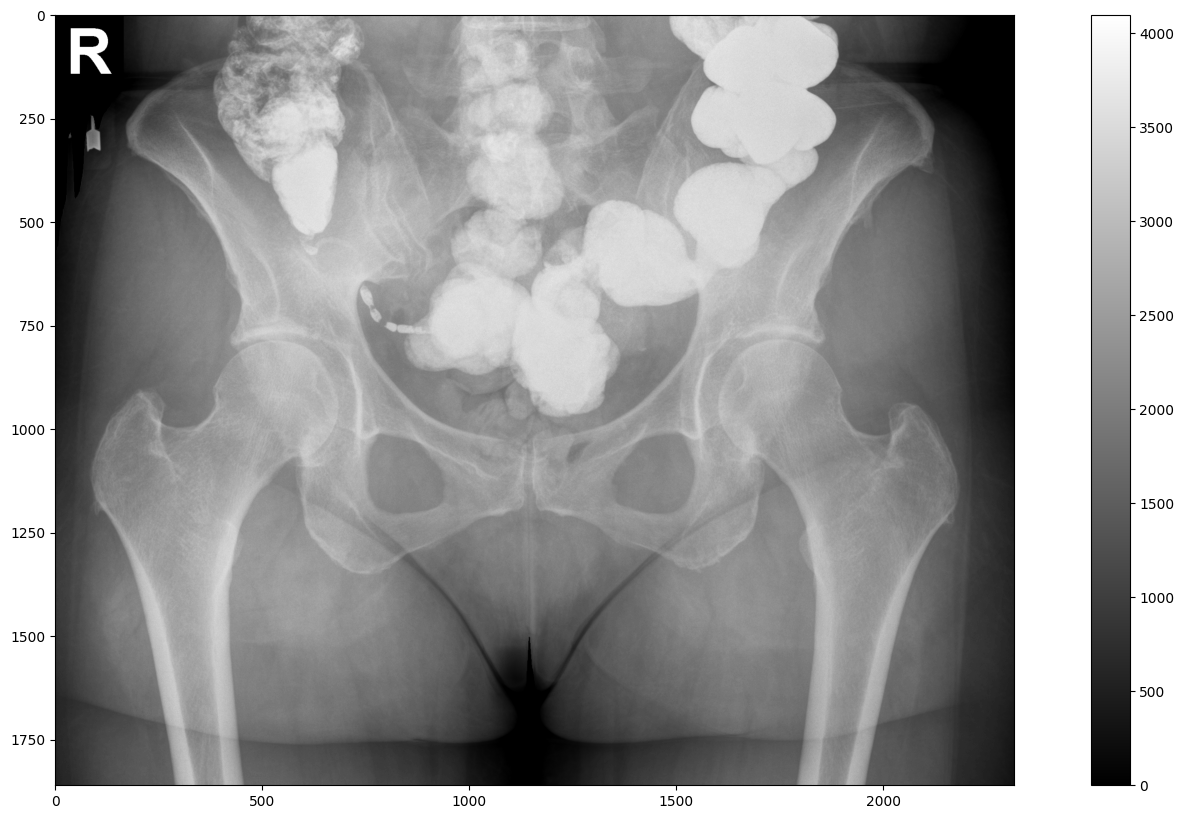

In [102]:
# Get the image pixel array.
dt.GetPixelArray()(dicom_container)

# Get the pixel spacing of original image (mm/pixel).
dt.GetSourcePixelSpacing()(dicom_container)

# Note that the image has a dimension added to it 
# to later match the dimension of the combined segmentation mask.
print(f'Pixel array ndim: {dicom_container.pixel_array.ndim}')
print(f'Pixel array shape: {dicom_container.pixel_array.shape}')

print(f'Pixel spacing: {dicom_container.source_pixel_spacing}')

plt.imshow(dicom_container.pixel_array[0], 'grey')
plt.colorbar()
pass

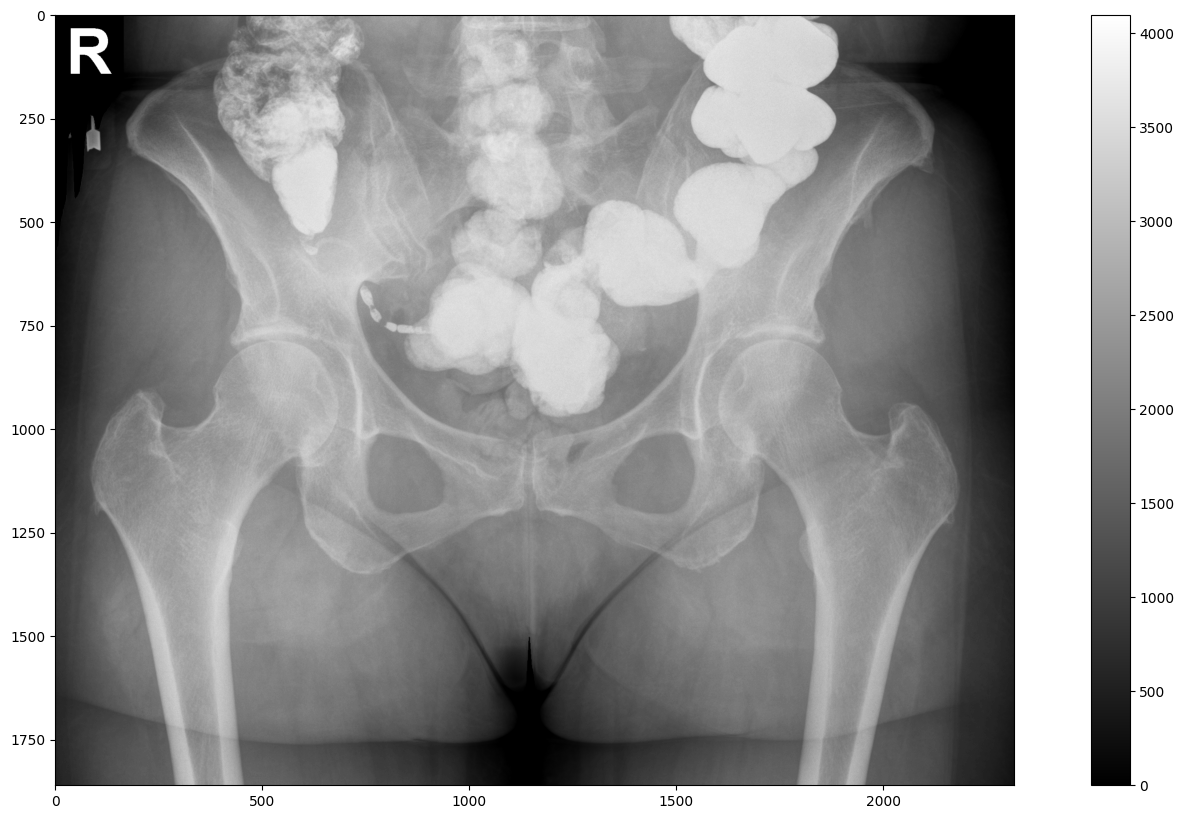

In [103]:
# Images may only be stored with either MONOCHROME1 (black and white)
# or MONOCHROME2 (white and black) as their photometric interpretation.
# If stored as MONOCHROME1, pixel intensities are flipped to MONOCHROME2.
dt.CheckPhotometricInterpretation()(dicom_container)
plt.imshow(dicom_container.pixel_array[0], 'grey')
plt.colorbar()
pass

In [104]:
# Our DICOM images must have their `VOILUT Function` property set to `LINEAR`.
dt.CheckVoilutFunction()(dicom_container)
pass

#### 1.1.2. Rescaling the image to the target pixel spacing

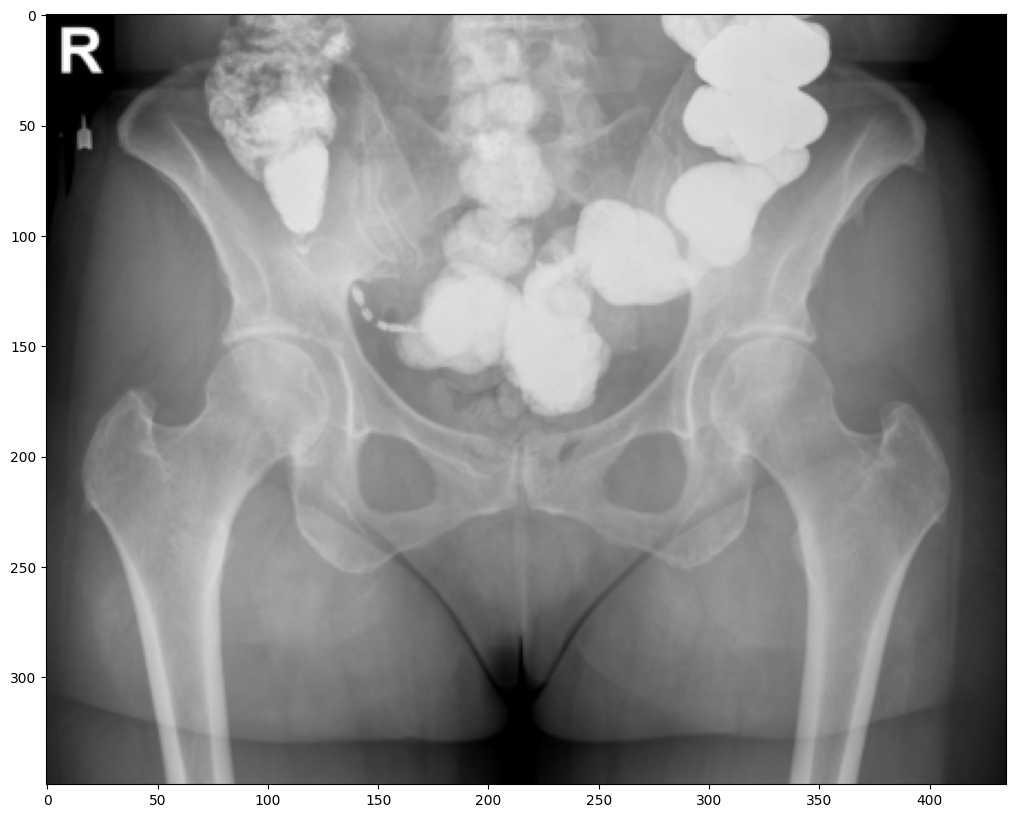

In [105]:
# Rescale image to a target pixel spacing.
# (NOTE: anisotropic pixel spacing is not supported).
# plt.subplot(2, 1, 1)
# plt.imshow(dicom_container.pixel_array[0], 'grey')

target_pixel_spacing = (0.9, 0.9)
dt.RescaleToTargetPixelSpacing(target_pixel_spacing)(dicom_container)

# plt.subplot(2, 1, 2)
plt.imshow(dicom_container.pixel_array[0], 'grey')
plt.show()
pass

#### 1.1.3. Pixel intensities Normalization

In [106]:
# Select two other `.dcm` files to compare with.
other_file_1 = all_files_meta[5]
other_file_2 = all_files_meta[7]

# Create containers for the two files.
other_container_1 = dt.DicomContainer(
    *other_file_1,
    hdf5_file_obj,
)
other_container_2 = dt.DicomContainer(
    *other_file_2,
    hdf5_file_obj,
)

# Apply the same transforms as before.
# To chain multiple transforms, one can use the `CombineTransforms`.
combined_transf = dt.CombineTransforms([
    dt.LoadDicomObject(),
    dt.GetPixelArray(),
    dt.GetSourcePixelSpacing(),
    dt.CheckPhotometricInterpretation(),
    dt.CheckVoilutFunction(),
])
combined_transf(other_container_1)
combined_transf(other_container_2)
pass

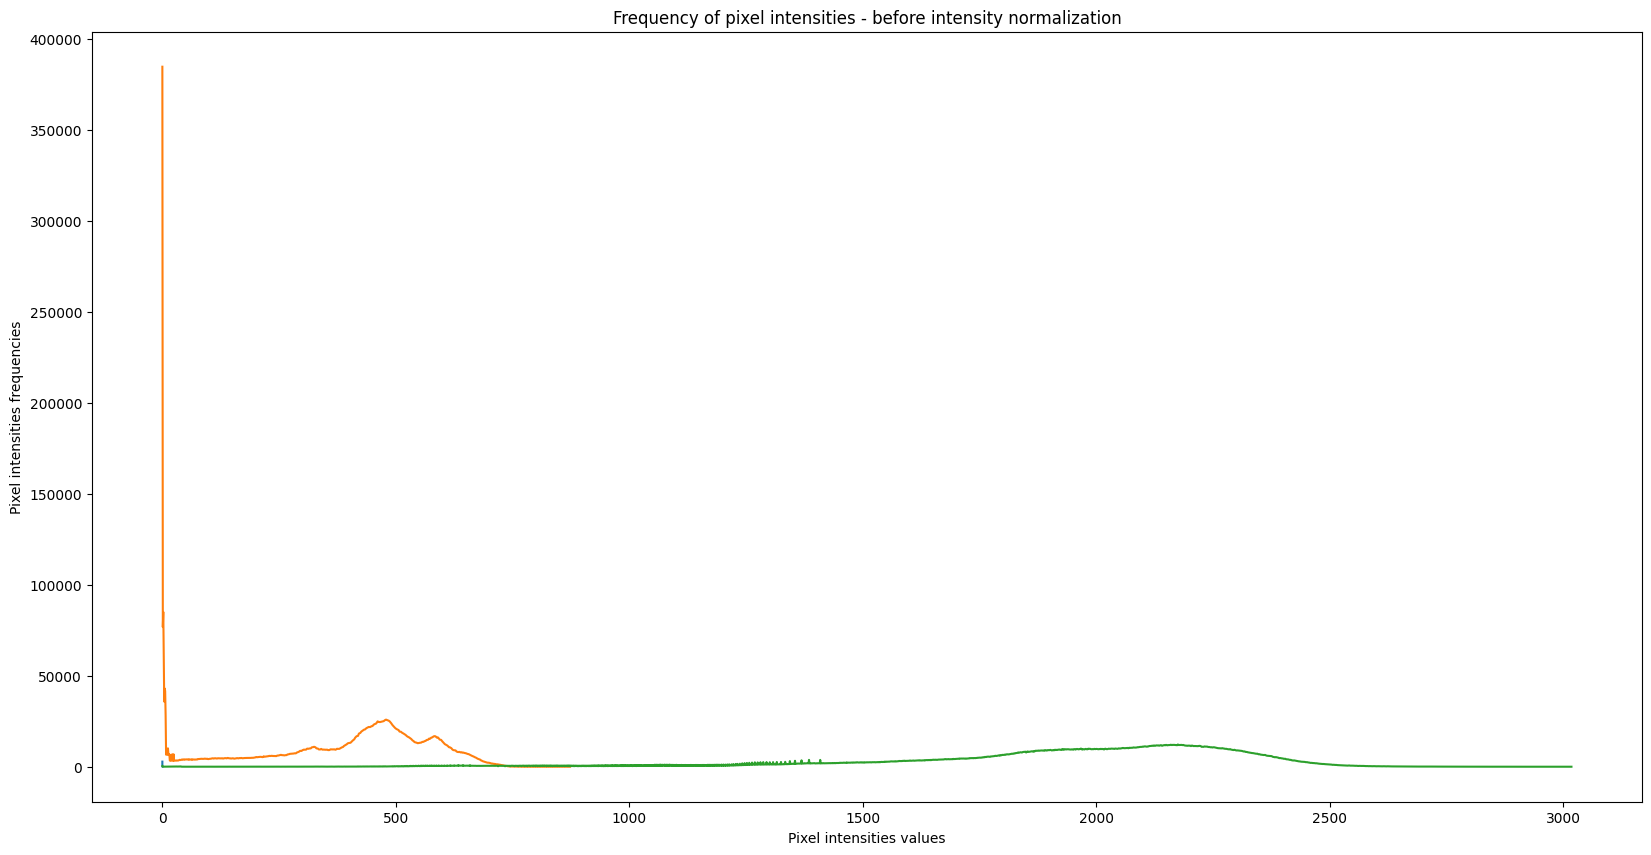

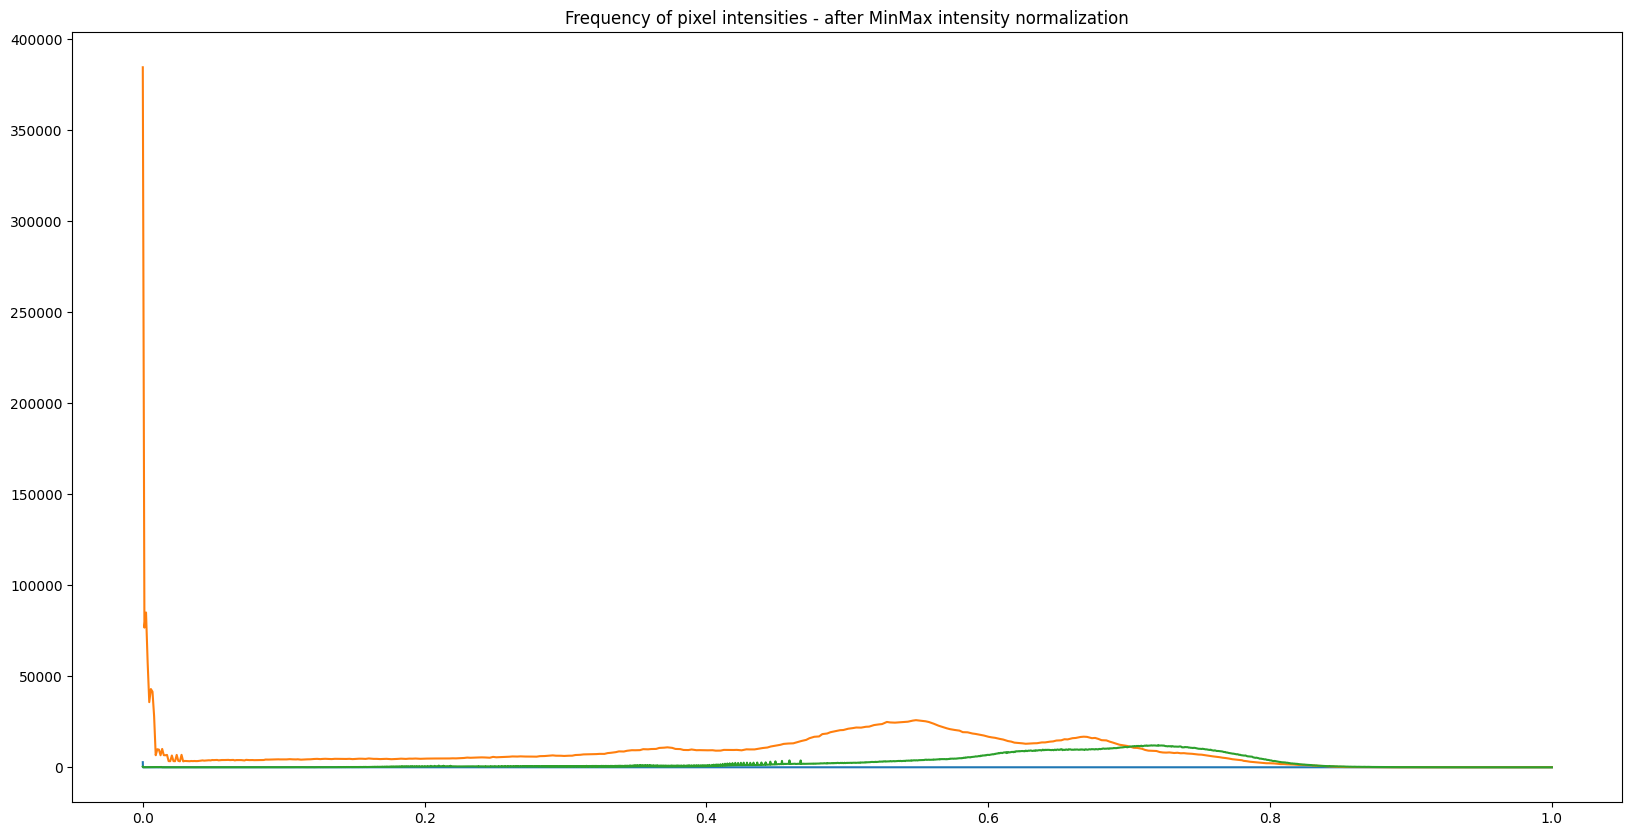

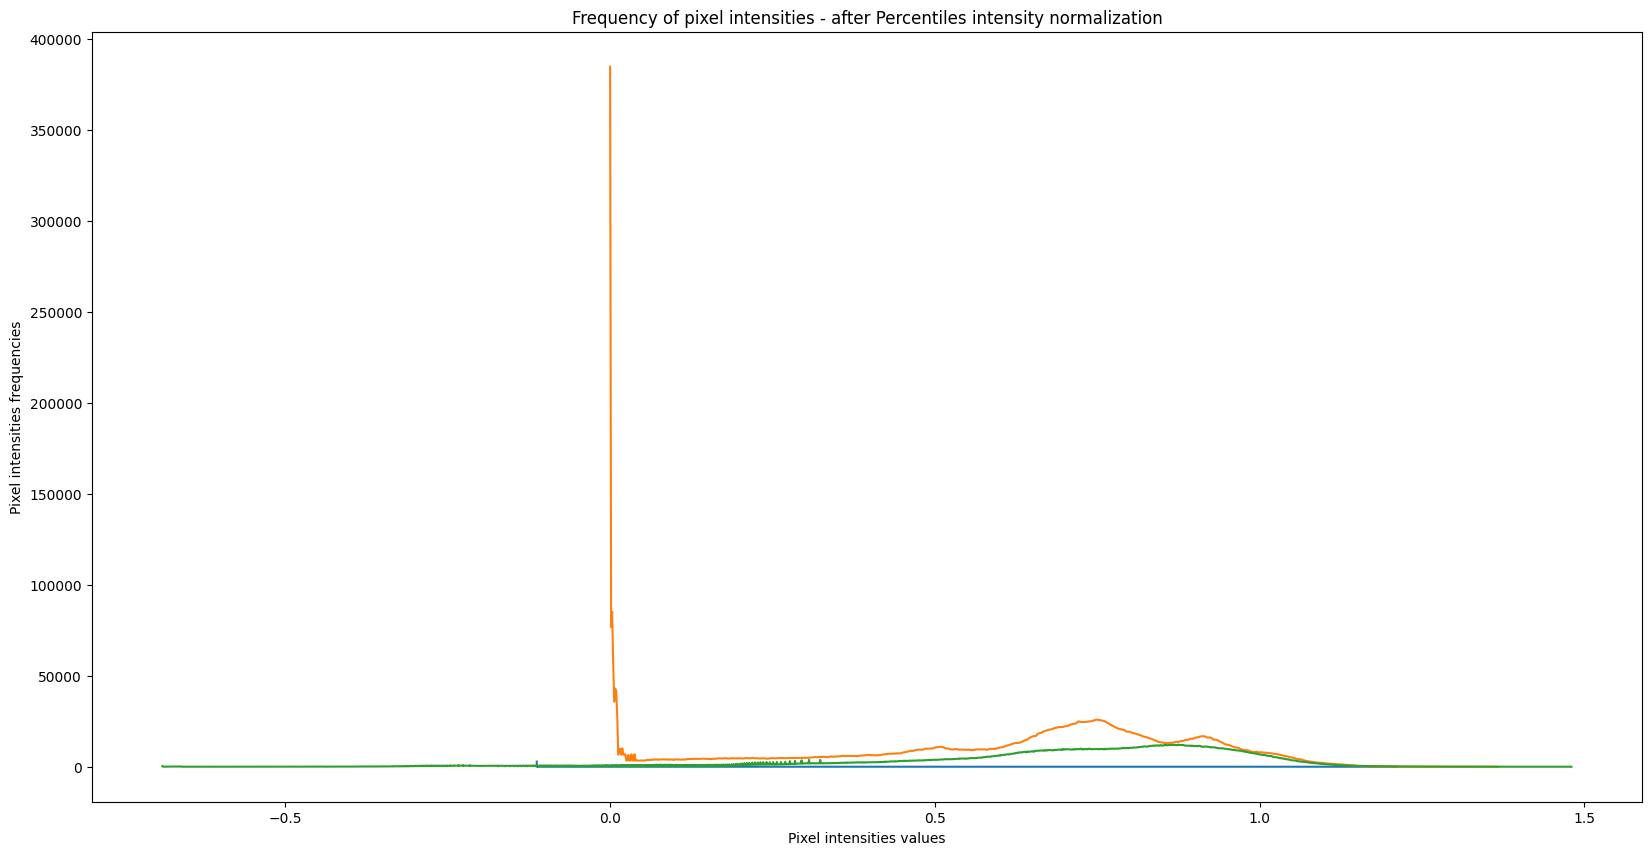

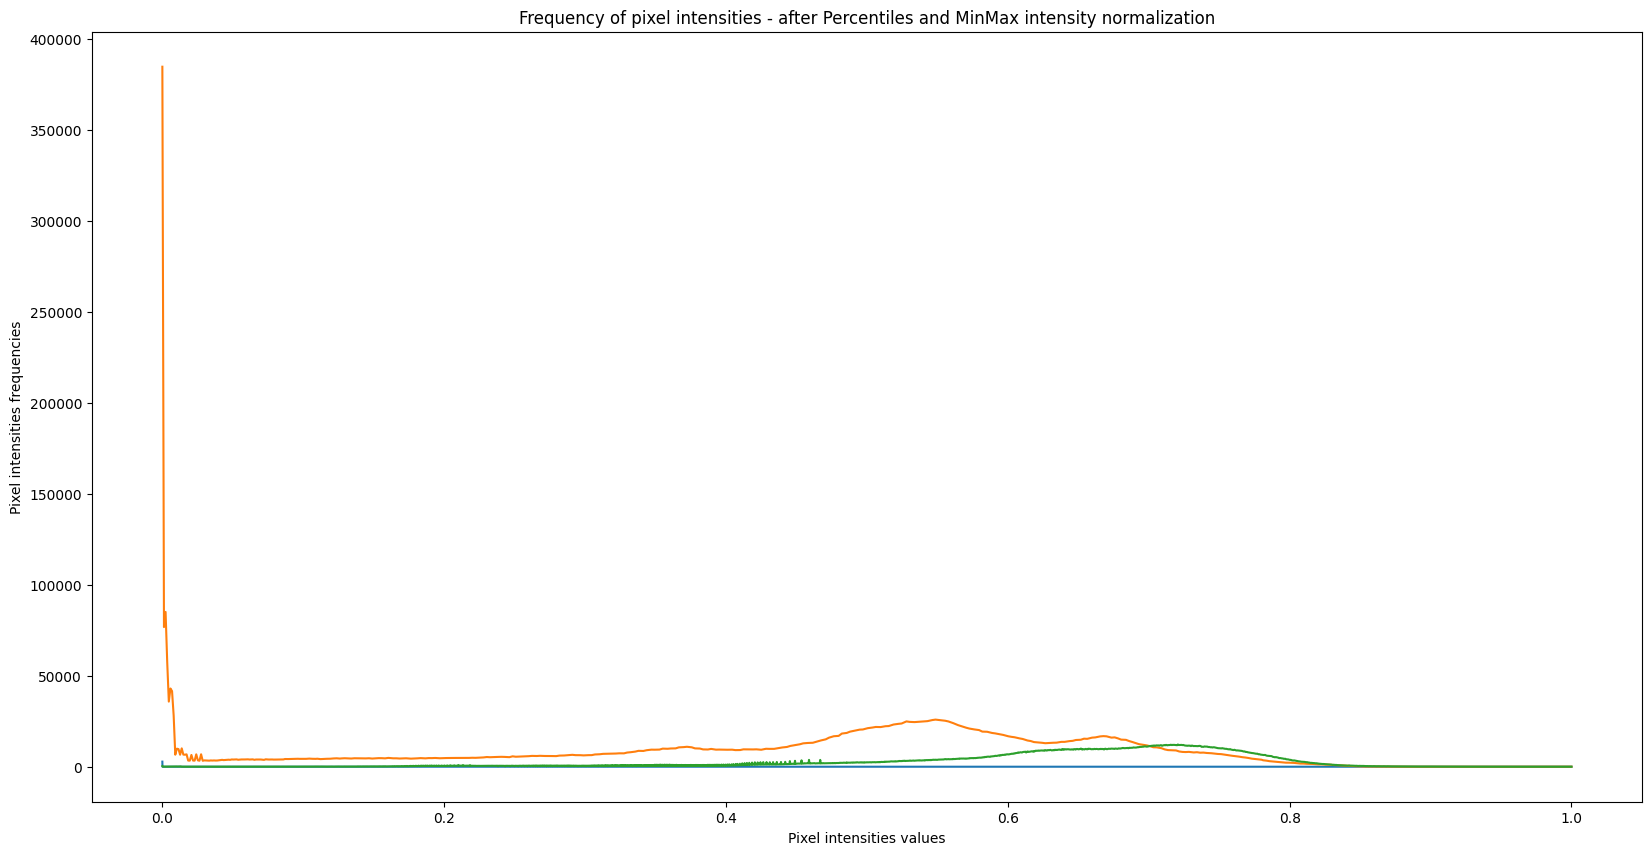

In [107]:
# Image without any intensity normalization applied.
from preprocessor_module.dicom_transforms import DicomContainer

plt.title('Frequency of pixel intensities - before intensity normalization')
for container in (dicom_container, other_container_1, other_container_2):
    intensities, frequencies = np.unique(container.pixel_array, return_counts=True)
    plt.plot(intensities, frequencies)
    plt.xlabel('Pixel intensities values')
    plt.ylabel('Pixel intensities frequencies')
plt.show()

# Apply min-max intensity normalization.
min_max_norm = dt.MinMaxIntensityNormalization()
plt.title('Frequency of pixel intensities - after MinMax intensity normalization')
for container in (dicom_container, other_container_1, other_container_2):

    copied_container = DicomContainer(None, None, None, None, None, None)   
    copied_container.pixel_array = np.copy(container.pixel_array)

    min_max_norm(copied_container)
    intensities, frequencies = np.unique(copied_container.pixel_array, return_counts=True)
    plt.plot(intensities, frequencies)
plt.show()


# Apply [5, 95] percentiles intensity normalization.
percentiles_normalization = dt.PercentilesIntensityNormalization((5, 95))
plt.title('Frequency of pixel intensities - after Percentiles intensity normalization')
for container in (dicom_container, other_container_1, other_container_2):
    percentiles_normalization(container)
    intensities, frequencies = np.unique(container.pixel_array, return_counts=True)
    plt.plot(intensities, frequencies)
    plt.xlabel('Pixel intensities values')
    plt.ylabel('Pixel intensities frequencies')
plt.show()


# Apply min-max intensity normalization.
min_max_norm = dt.MinMaxIntensityNormalization()
plt.title('Frequency of pixel intensities - after Percentiles and MinMax intensity normalization')
for container in (dicom_container, other_container_1, other_container_2):
    min_max_norm(container)
    intensities, frequencies = np.unique(container.pixel_array, return_counts=True)
    plt.plot(intensities, frequencies)
    plt.xlabel('Pixel intensities values')
    plt.ylabel('Pixel intensities frequencies')
plt.show()
pass

#### 1.1.4. Padding

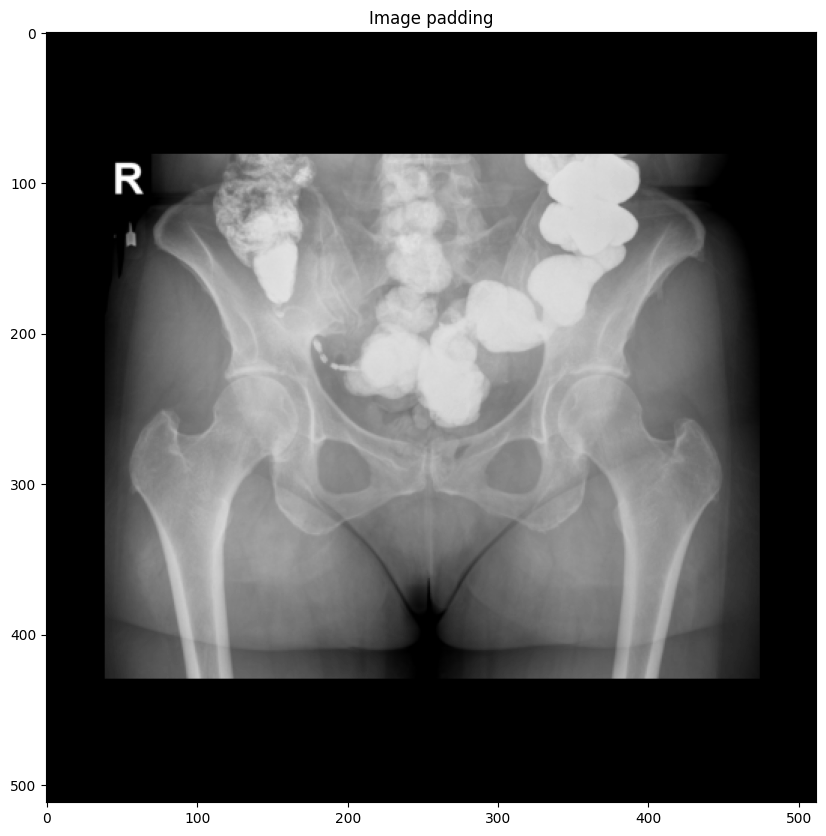

In [108]:
# Pad image to reach target image shape.
# (NOTE: if image shape is larger than the
# target shape, the image is discarded).
target_shape = (512, 512)
dt.PadSymmetrically(target_shape)(dicom_container)
plt.title('Image padding')
plt.imshow(dicom_container.pixel_array[0], 'grey')
plt.show()

#### 1.1.5. Segmentation masks

In [109]:
# Get the BoneFinder points generated for the our image
# from the corresponding `.dcm.pts` file.
dt.GetBoneFinderPoints()(dicom_container)
print('BoneFinder points (list of pixel coordinates in mm):\n', dicom_container.bonefinder_points)

BoneFinder points (list of pixel coordinates in mm):
 [[ 32.5506 227.753 ]
 [ 28.5201 217.041 ]
 [ 22.65   206.636 ]
 [ 15.3428 198.143 ]
 [ 15.6588 180.798 ]
 [ 22.4096 166.616 ]
 [ 32.4514 154.513 ]
 [ 36.059  154.972 ]
 [ 43.0977 166.294 ]
 [ 46.0296 167.769 ]
 [ 49.2895 168.426 ]
 [ 52.8027 168.313 ]
 [ 56.3848 167.667 ]
 [ 59.8182 166.507 ]
 [ 62.523  164.337 ]
 [ 64.1888 161.282 ]
 [ 64.913  157.592 ]
 [ 65.0445 153.406 ]
 [ 65.7458 148.901 ]
 [ 69.3382 143.278 ]
 [ 73.5278 138.935 ]
 [ 83.9737 133.559 ]
 [ 95.2885 133.355 ]
 [105.444  137.983 ]
 [112.624  147.012 ]
 [115.729  159.047 ]
 [112.572  170.899 ]
 [103.574  180.237 ]
 [ 93.0532 184.133 ]
 [ 84.3247 192.615 ]
 [ 78.8137 202.383 ]
 [ 75.0915 211.699 ]
 [ 76.867  214.717 ]
 [ 75.7306 220.582 ]
 [ 71.8155 224.49  ]
 [ 38.4702 152.438 ]
 [ 41.7444 154.195 ]
 [ 44.5903 160.572 ]
 [ 42.6131 169.342 ]
 [ 46.4687 180.781 ]
 [ 75.4431 139.19  ]
 [ 78.8764 148.055 ]
 [ 84.6308 160.458 ]
 [ 91.8134 173.76  ]
 [ 99.731  183.615 ]
 

Segmentation masks shapes:
    - right: (4, 512, 512);
    - left: (4, 512, 512);



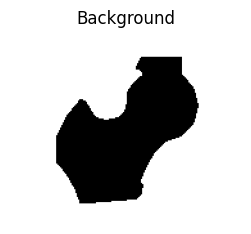

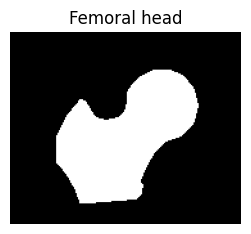

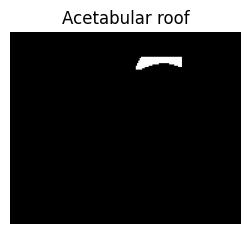

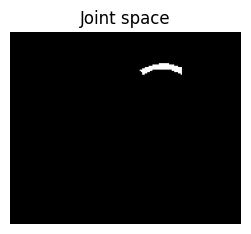

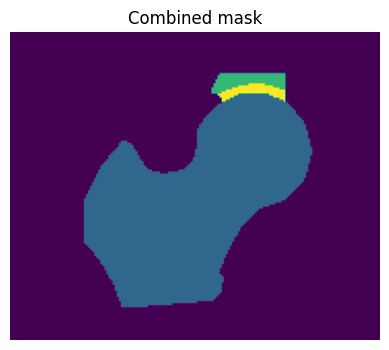

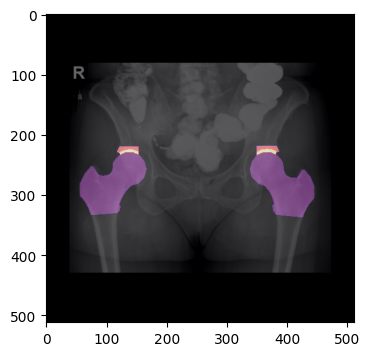

In [145]:
# Draw segmentation masks for both the right and left sides of the hip using BoneFinder points.
# There is the option of including or not the background mask.
dt.GetSegmentationMasks(include_background_mask = True)(dicom_container)

print(
    f'Segmentation masks shapes:\n'
    f'    - right: {dicom_container.right_segmentation_mask.shape};\n'
    f'    - left: {dicom_container.left_segmentation_mask.shape};\n'
)

# Show the overlapped masks.
# plt.title('Right side segmentation mask')
# plt.imshow(sum((idx + 1) * mask for idx, mask in enumerate(dicom_container.right_segmentation_mask)), 'magma')
# plt.show()
plt.rcParams['figure.figsize'] = [5, 2.5]

plt.axis('off')
plt.title('Background')
plt.imshow(dicom_container.right_segmentation_mask[0][200:350, 20:200], 'grey')
plt.show()

plt.axis('off')
plt.title('Femoral head')
plt.imshow(dicom_container.right_segmentation_mask[1][200:350, 20:200], 'grey')
plt.show()

plt.axis('off')
plt.title('Acetabular roof')
plt.imshow(dicom_container.right_segmentation_mask[2][200:350, 20:200], 'grey')
plt.show()

plt.axis('off')
plt.title('Joint space')
plt.imshow(dicom_container.right_segmentation_mask[3][200:350, 20:200], 'grey')
plt.show()

plt.rcParams['figure.figsize'] = [8, 4]
plt.axis('off')
plt.title('Combined mask')
plt.imshow(
    sum((idx + 1) * mask for idx, mask in enumerate(dicom_container.right_segmentation_mask))[200:350, 20:200],
    # 'magma',
)
plt.show()

# plt.title('Left side segmentation mask')
plt.imshow(dicom_container.pixel_array[0], 'grey')
plt.imshow(
    sum((idx + 1) * mask for idx, mask in enumerate(dicom_container.right_segmentation_mask)) + \
    sum((idx + 1) * mask for idx, mask in enumerate(dicom_container.left_segmentation_mask )),
    'magma',
    alpha=0.6
)
plt.show()
pass

#### 1.1.6. Writing to HDF5

In [111]:
# Write image, right side segmentation mask metadata from the `DicomContainer` to the HDF5 file
# dt.AppendDicomToHDF5('right')(dicom_container)
pass

In [120]:
# # To write the segmentation mask for the left side,
# # we need to first flip the image and the masks,
# # such that the left hip and the left hip mask are 
# # now on the right side of the hip.
# dt.Flip(axis=-1)(dicom_container)

# # Write image, left side segmentation mask metadata from the `DicomContainer` to the HDF5 file
# dt.AppendDicomToHDF5('left')(dicom_container)

# # Close the HDF5 file
# dicom_container.hdf5_file_object.close()
pass

### 1.2. Full preprocessing pipeline

In [113]:
# # Set preprocessing parameters here >>>
# data_dir_path            = './data'
# hdf5_filepath            = './my_hdf5_file.h5'
# percentiles              = (5, 95)
# target_pixel_spacing     = (0.9, 0.9)
# target_pixel_array_shape = (512, 512)
# include_background_mask  = True
# verbose                  = True
# # <<< Set preprocessing parameters here

# dicom_files_metadata = lf.ListDicomFiles(data_dir_path)()

# with h5py.File(hdf5_filepath, 'w') as hdf5_file_object:

#     dicom_transforms_base = dt.CombineTransforms([
#         dt.LoadDicomObject(),
#         dt.GetPixelArray(),
#         dt.GetSourcePixelSpacing(),
#         dt.CheckPhotometricInterpretation(),
#         dt.CheckVoilutFunction(),

#         dt.RescaleToTargetPixelSpacing(target_pixel_spacing),

#         dt.PercentilesIntensityNormalization(percentiles),
#         dt.MinMaxIntensityNormalization(),

#         dt.PadSymmetrically(target_pixel_array_shape),

#         dt.GetBoneFinderPoints(),
#         dt.GetSegmentationMasks(include_background_mask),
#     ])

#     for meta in tqdm.tqdm(dicom_files_metadata):
#         # Un-wrap DICOM file metadata
#         (
#             dicom_file_path,
#             points_file_path,
#             dataset,
#             subject_id,
#             subject_visit,
#         ) = \
#             meta

#         # Create container of DICOM file data on which to apply the transforms
#         dicom_container = dt.DicomContainer(
#             dicom_filepath   = dicom_file_path,
#             points_filepath  = points_file_path,
#             dataset          = dataset,
#             subject_id       = subject_id,
#             subject_visit    = subject_visit,
#             hdf5_file_object = hdf5_file_object,
#         )

#         try:
#             # Apply the transforms base.
#             dicom_transforms_base(dicom_container)

#             # Write the unflipped image and the mask
#             # for segmenting the right hip to the HDF5 file.
#             dt.AppendDicomToHDF5(hip_side=ct.HipSide.RIGHT)(dicom_container)

#             # Flip the image and the segmentation masks.
#             dt.Flip(axis=-1)(dicom_container)

#             # Write the flipped image and the flipped mask 
#             # for segmenting the left hip to the HDF5 file.
#             dt.AppendDicomToHDF5(hip_side=ct.HipSide.LEFT)(dicom_container)

#         except dt.PreprocessingException as e:
#             if verbose:
#                 print(e)

#     hdf5_file_object.close()

## 2. Model training

In [114]:
image = np.zeros((4, 5, 5))

image[0, 0, 0] = 4
image[1, 0, 0] = 3
image[2, 0, 0] = 16
image[3, 0, 0] = 2

transf = Compose([
    Activations(softmax = True),
    AsDiscrete(
        argmax  = True,
        to_onehot = 4,
    ),
])

image = transf(image)
image

metatensor([[[0., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.]],

        [[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]],

        [[1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]]])

In [115]:
import shapely
from shapely.geometry import (
    Point,
    LineString,
    Polygon,
)

2.0554804791094465


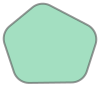

In [116]:
p1 = Point(4.98, 3.48)
p2 = Point(5.13, 1.43)

print(p1.distance(p2))

line = LineString([p1, p2])

polygon = Polygon([
    (-72.2792869, 42.9317646),
    (-72.2807029, 42.9306023),
    (-72.2801236, 42.9288589),
    (-72.2775063, 42.9288903),
    (-72.2769699, 42.9305552),
    (-72.2792869, 42.9317646),
]).buffer(0.001)
polygon

# -72.2831303, 42.9263108
# -72.2825832, 42.9264600
# -72.2820147, 42.9264914
# -72.2811458, 42.9264600
# -72.2803627, 42.9263893
# -72.2790326, 42.9262008
# -72.2786142, 42.9261066
# -72.2777454, 42.9259024
# -72.2771232, 42.9257060

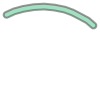

In [117]:
curve = LineString([
    (-72.2858127, 42.9133386),
    (-72.2831125, 42.9145595),
    (-72.2799538, 42.9154205),
    (-72.2762718, 42.9160304),
    (-72.2726829, 42.9162293),
    (-72.2690964, 42.9158795),
    (-72.2654745, 42.9151610),
    (-72.2627707, 42.9141572),
    (-72.2602826, 42.9128673),
    (-72.2575093, 42.9113913),
    (-72.2554341, 42.9095993),
])

curve.buffer(0.001)